In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
from helpers import *
from model import *
import os,sys
from PIL import Image

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D,Conv2D
from keras.optimizers import Adam
from keras.utils import np_utils
from keras import backend as K
from keras.regularizers import l2
from keras.layers import LeakyReLU
from keras.callbacks import ReduceLROnPlateau, EarlyStopping


/Users/Skolebruker/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Load files, either from google or local drive

In [2]:
# Loaded a set of images
drivedir = "drive/My Drive/"
root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)

In [3]:
#Take in original images
n = min(100, len(files)) # Load maximum 100 images
print("Loading " + str(n) + " original images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

#take in ground truth
gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " ground truth-images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

Loading 100 original images
satImage_052.png
Loading 100 ground truth-images
satImage_052.png


### Take a look at format of images

Image size = 400,400


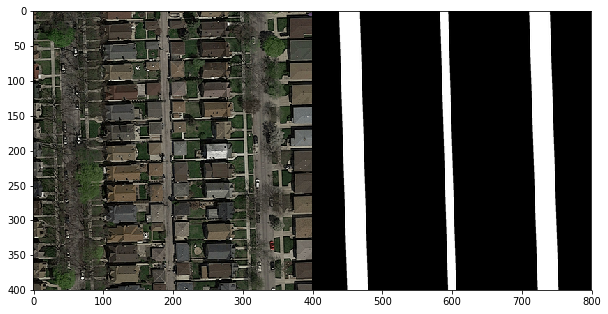

In [4]:
print('Image size = ' + str(imgs[0].shape[0]) + ',' + str(imgs[0].shape[1]))

# Show first image and its groundtruth image
cimg = concatenate_images(imgs[0], gt_imgs[0])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

### Slice images into patches

In [5]:
def make_patches(patch_size,n_images):
    # Extract patches from input images
    img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n_images)]
    gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n_images)]
    # Linearize list of patches
    #shape is 10*625 (10 images, cut up into 625 images with 16*16)
    img_patches=np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])    
    gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])
    return img_patches, gt_patches
    
img_patches, gt_patches = make_patches(16, 100)
    

In [6]:
# Compute features for each image patch
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch
Y = np.asarray([value_to_class(np.mean(gt_patches[i]),foreground_threshold) for i in range(len(gt_patches))])


In [7]:
def add_rotated_imgs(img_patches,Y):
    original_picture_count = len(img_patches)
    new_imgs = img_patches.copy()
    new_Y = Y.copy()
    for i in range(1,4):
        flip_img = img_patches.copy()
        for j in range (original_picture_count):
            flip_img[j] = np.rot90(img_patches[j], i)
        new_imgs = np.concatenate((new_imgs, flip_img), axis=0)
        new_Y = np.concatenate((new_Y, Y.copy()), axis=0)
    return new_imgs, new_Y

new_imgs, new_Y = add_rotated_imgs(img_patches, Y)


In [8]:
x_train, x_test, y_train, y_test = split_data(new_imgs,new_Y,0.1)

X = np.asarray([ extract_features_2d(x_test[i]) for i in range(len(x_test))])

In [9]:
# Print feature statistics
def get_info(X, Y):
    print('Computed ' + str(X.shape[0]) + ' features')
    print('Feature dimension = ' + str(X.shape[1]))
    print('Number of classes = ' + str(len(set(Y))))  #TODO: fix, length(unique(Y)) 

    Y0 = [i for i, j in enumerate(Y) if j == 0]
    Y1 = [i for i, j in enumerate(Y) if j == 1]
    print('Class 0: ' + str(len(Y0)) + ' samples')
    print('Class 1: ' + str(len(Y1)) + ' samples')
    return Y1, Y0
Y1, Y0 = get_info(X,Y)

Computed 225000 features
Feature dimension = 2
Number of classes = 2
Class 0: 46309 samples
Class 1: 16191 samples


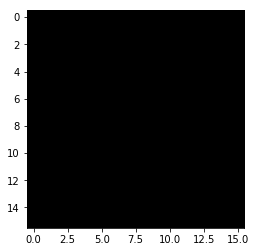

In [10]:
# Display a patch that belongs to the foreground class
def show_patch(patches, clas,number):
    plt.imshow(patches[clas[number]], cmap='Greys_r')
show_patch(gt_patches, Y0, 100)

In [11]:
# Plot 2d features using groundtruth to color the datapoints
# Rødt er vei
def scatter_plot(X,c):
    plt.scatter(X[:, 0], X[:, 1], c=c, edgecolors='k', cmap=plt.cm.Paired)


In [12]:
model = make_model(16, 2)



/Users/Skolebruker/Documents/GitHub/MLproject/model.py:35: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), input_shape=(16, 16, 3..., padding="same")`
  model.add(Conv2D(64, (5,5), border_mode="same", input_shape=input_shape))
/Users/Skolebruker/Documents/GitHub/MLproject/model.py:39: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
  model.add(Conv2D(128, (3, 3), border_mode="same"))
/Users/Skolebruker/Documents/GitHub/MLproject/model.py:40: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), padding="same")`
  model.add(Conv2D(256, (3, 3), border_mode="same"))


In [140]:
print(x_train.shape)
model.fit(x_train,y_train,batch_size=1000, epochs = 4)


(25000, 16, 16, 3)
Epoch 1/4
25000/25000 [==============================] - 119s 5ms/step - loss: 0.5371 - acc: 0.7460
Epoch 2/4
25000/25000 [==============================] - 93s 4ms/step - loss: 0.5158 - acc: 0.7460
Epoch 3/4
25000/25000 [==============================] - 124s 5ms/step - loss: 0.4950 - acc: 0.7487
Epoch 4/4
25000/25000 [==============================] - 128s 5ms/step - loss: 0.4711 - acc: 0.7612


In [14]:
def scores(pred,truth):
    pred = np.nonzero(pred)[0]
    truth = np.nonzero(truth)[0]
    TP = len(list(set(truth) & set(pred)))
    FP = len(pred)-TP
    FN = len(truth)-TP
    Precision = TP / (TP+FP+K.epsilon())
    Recall = TP / (TP+FN+K.epsilon())
    F1 = 2*Recall*Precision/(Recall+Precision+K.epsilon())
    return F1, Precision, Recall

In [141]:
# Predict on the training set
def get_best_prediction(x_test, model):
    Z = model.predict(x_test)
    max_f1 = best_tresh = 0
    best_rec = 0 
    best_prec = 0
    best_Z = Z
    for tresh in np.linspace(0.2,0.7,25): 
        Z_copy = Z.copy()
        for i in range (len(Z_copy)):
            if(Z_copy[i]<tresh):
                Z_copy[i] =0
            else:
                Z_copy[i]=1

        F1, Precision, Recall = scores(Z_copy, y_test)
        if(F1 > max_f1):
            best_Z = Z_copy.copy()
            max_f1 = F1
            best_tresh = tresh
            best_rec = Recall
            best_prec = Precision
    best_Z = np.reshape(best_Z, y_test.shape) # C-like index ordering
    print('Precision = ' + str(best_prec))
    print('Recall = ' + str(best_rec))
    print('F1 = ' + str(max_f1))
    print("Best_tres = "+str(best_tresh))
    return best_Z
pred = get_best_prediction(x_test,model)

KeyboardInterrupt: 

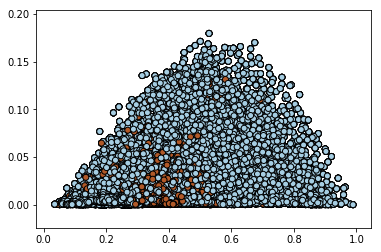

In [16]:
# Plot features using predictions to color datapoints
#Rødt er predicted til å være vei
scatter_plot(X,pred)
scatter_plot(X,y_test)

In [20]:
# Run prediction on the img_idx-th image
def predict_images(images, patch_size):
    foreground_treshold = 0.25
    Xi = [img_crop(imgs[i], patch_size, patch_size) for i in images]
    Xi = np.asarray([Xi[i][j] for i in range(len(images)) for j in range(len(Xi[i]))]) 
    correct_labeling_testimg = [img_crop(gt_imgs[i], patch_size, patch_size) for i in images]
    correct_labeling_testimg = np.asarray([correct_labeling_testimg[i][j] for i in range(len(images))
                                            for j in range(len(correct_labeling_testimg[i]))])
    correct_labeling_testimg = np.asarray([value_to_class(np.mean(correct_labeling_testimg[i]),foreground_treshold)
                                           for i in range(len(correct_labeling_testimg))])
    Zi = model.predict(Xi)
    for i in range (len(Zi)):
        if(Zi[i]<0.3):
            Zi[i] =0
        else:
            Zi[i]=1
    Zi = np.reshape(Zi, ((625*len(images)),))
    Xmap = np.asarray([ extract_features_2d(Xi[i]) for i in range(len(Xi))])
    plt.scatter(Xmap[:, 0], Xmap[:, 1], c=Zi, edgecolors='k', cmap=plt.cm.Paired)
    return Zi, correct_labeling_testimg

In [106]:
def take_isolated(array, image_shape):
    new = array.copy()
    for i in range(len(array)):
        road = False
        if(array[i]==1):
            road = True
        row = i%image_shape
        col = i//image_shape
        #print("col: ",col, "row: ", row, "Road: ",array[i])
        score = 0
        for j in range(row-1,row+2):
            for k in range(col-1,col+2):
                if ((j>=image_shape) or (j <0) or(k <0) or (k>=image_shape)):
                    score +=1
                    continue
                if((road and array[k*image_shape+j] ==0) or 
                   (not road and array[k*image_shape+j] ==1)):
                    score += 1
        if(score ==8):
            if(road):
                new[col*image_shape+row] = 0
            else:
                new[col*image_shape+row] = 1
    return new
            
    

In [138]:
def find_clique(array, image_shape):
    neighbours = []
    clique_size = array.copy()
    for i in range(len(array)):
        if(array[i] == 1):
            row = i%image_shape
            col = i//image_shape
            neighbours.append(set())
            neighbours[i].add(i)
            if((row>=image_shape-1) or (row<=0) or (col>=image_shape-1) or (col<=0)):
                neighbours[i].add(-1)
                #large value if on edge of image
        else:
            neighbours.append(None)
    count = 0
    while (count <1):
        count+=1
        for col in range(1,image_shape-1):
            for row in range(1,image_shape-1):
                if(neighbours[col*image_shape+row] is not None): 
                    for j in range(row-1,row+2):
                        #if(col>20):
                         #   print("tjong")
                        for k in range(col-1,col+2):
                            if(neighbours[k*image_shape+j] is not None):
                                neighbours[col*image_shape+row].update(neighbours[k*image_shape+j]) 
        #backwards
        for col in range(image_shape-2,0,-1):
            for row in range(image_shape-2,0,-1):
                if(neighbours[col*image_shape+row] is not None): 
                    for j in range(row-1,row+2):
                        for k in range(col-1,col+2):
                            if(neighbours[k*image_shape+j] is not None):
                                neighbours[col*image_shape+row].update(neighbours[k*image_shape+j]) 
    for i in range(len(array)):
        if(neighbours[i] is None):
            clique_size[i] =0
        elif(-1 in neighbours[i]):
            clique_size[i] =100
        else: 
            clique_size[i] == len(neighbours[i])
            
    return clique_size


[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0 100 100 100 100
 100 100 100 100 100 100   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   

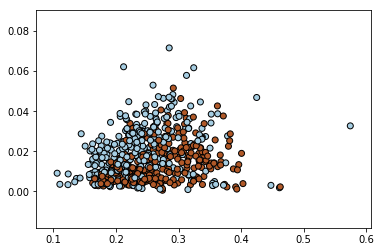

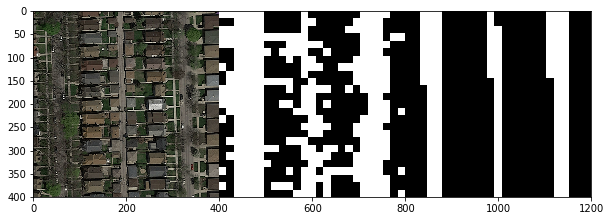

In [142]:
# Display prediction as an image
def show_prediction(Zi, correct_labeling_testimg, images):
    patch_size = 16
    i = 0
    patches_per_image = len(Zi)/len(images)
    for index in images:
        pred = Zi[int(i*patches_per_image):int((i+1)*patches_per_image)]
        correct = correct_labeling_testimg[int(i*patches_per_image):int((i+1)*patches_per_image)]
        pred = take_isolated(pred, 25)
        print(find_clique(correct,25))           
        w = gt_imgs[index].shape[0]
        h = gt_imgs[index].shape[1]
        predicted_im = label_to_img(w, h, patch_size, patch_size, pred)
        correct_im = label_to_img(w, h, patch_size, patch_size, correct)
        cimg = concatenate_images(imgs[index], predicted_im)
        cimg = concatenate_images(cimg, correct_im)
        fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
        plt.imshow(cimg, cmap='Greys_r')
        i+=1
    return

images =[0]
Zi,correct_labeling_testimg = predict_images(images,16)       
show_prediction(Zi, correct_labeling_testimg, images)


In [97]:
new_img = make_img_overlay(imgs[0], predicted_im)

plt.imshow(new_img)

NameError: name 'predicted_im' is not defined